In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Random 充電/放電結果

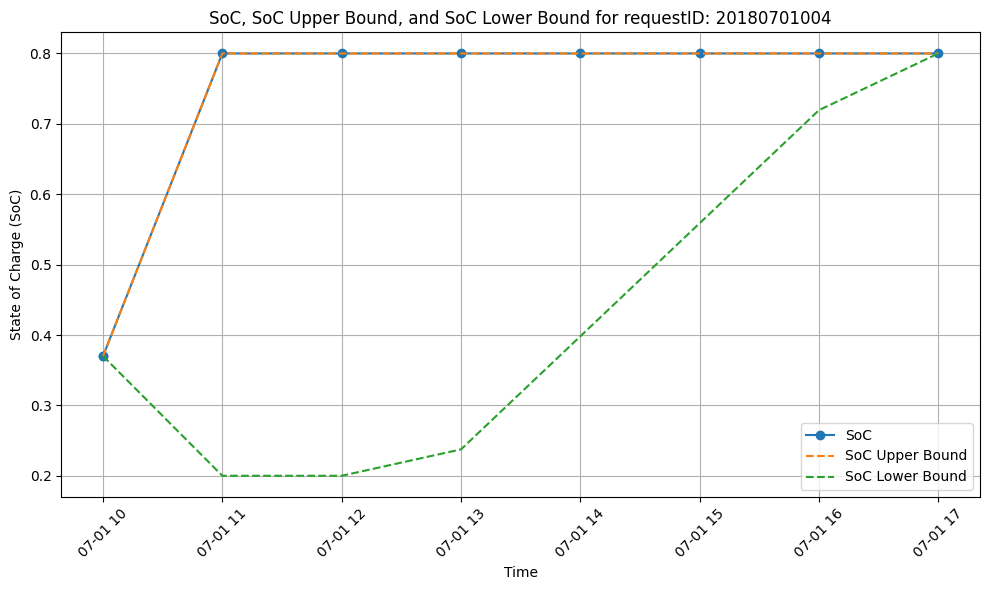

In [4]:
# Read the CSV file
file_path = './Result/Unschedule/1/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage 
plot_soc_for_requestID(20180701004)  # Replace with the desired requestID


## MARL 充電/放電結果

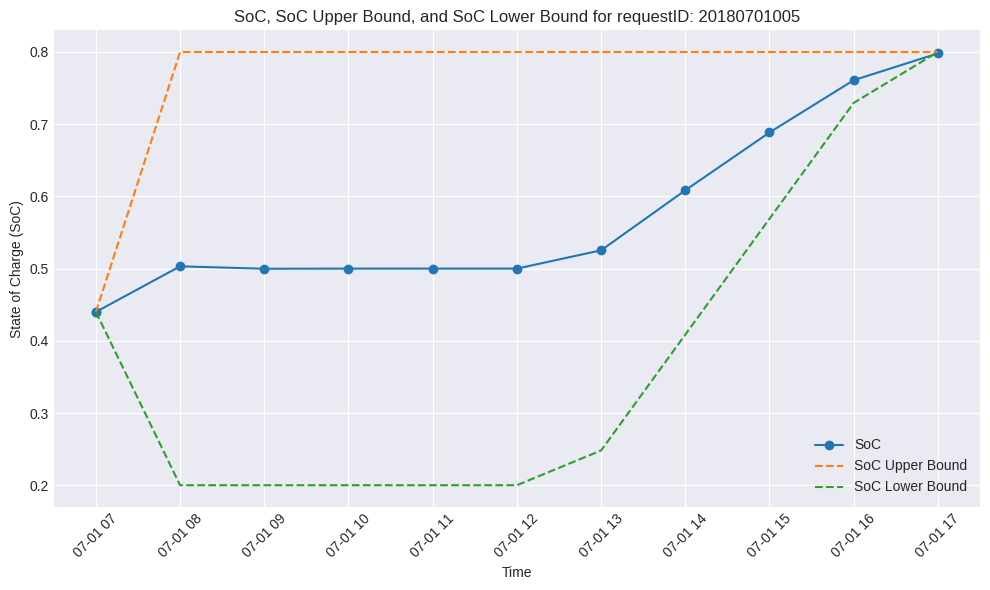

In [65]:
# Read the CSV file
file_path = './Result/MADDPG/312/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage
plot_soc_for_requestID(20180701005)  # Replace with the desired requestID


## 原始負載與 EV 充放電的負載變化圖

In [4]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

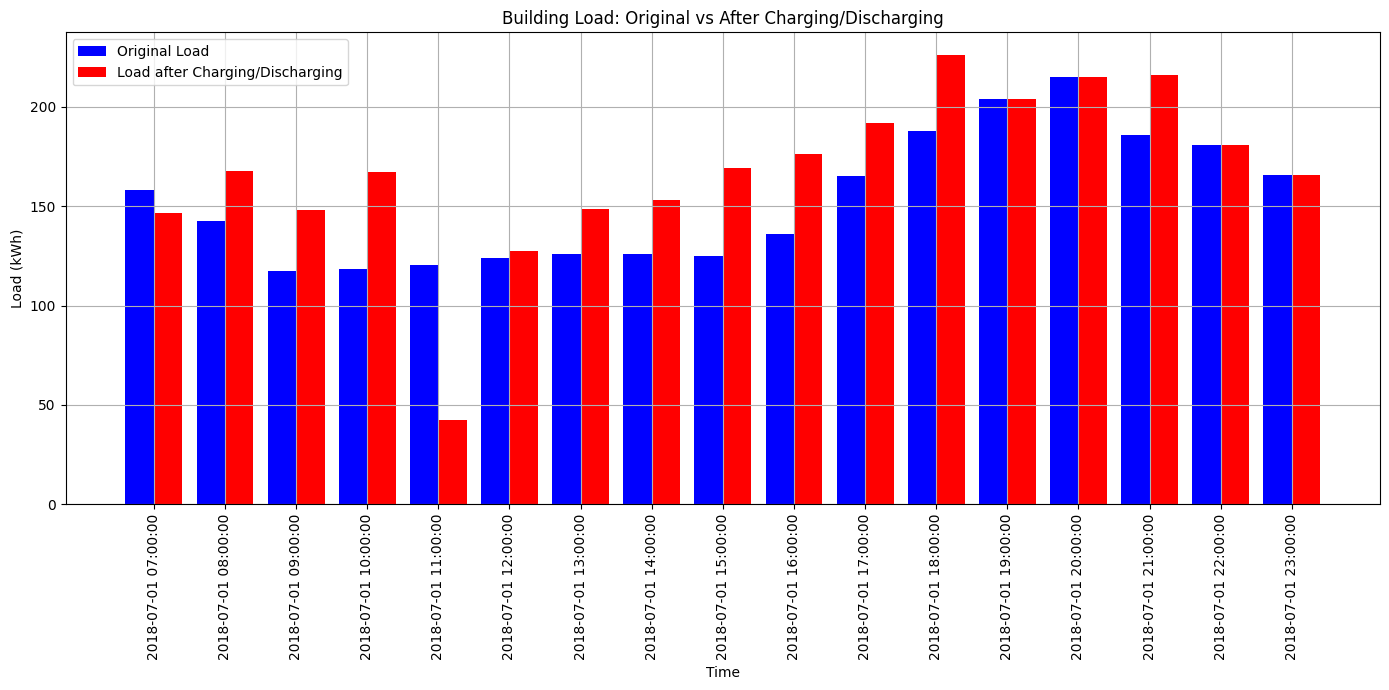

In [6]:
file_path = './Result/TEST/11/building_loading_history.csv'  # Modify this to the path of your load history file
start_date = '2018-07-01'
end_date = '2018-07-02'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

plot_load_history(file_path, start_date, end_date)

## 計算峰谷比 (Peak-to-Valley Ratio)

In [7]:
start_date = '2018-07-01'
end_date = '2018-07-01'
start_hour = 8
end_hour = 18

start_time = datetime.strptime(f'{start_date} {start_hour}:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(f'{end_date} {end_hour}:00:00', '%Y-%m-%d %H:%M:%S')

In [10]:
df = pd.read_csv(file_path, parse_dates=['current_time'])
df['current_time'] = pd.to_datetime(df['current_time'])

def calculate_peak_to_valley_ratio(df, start_time, end_time):
    
    mask = (df['current_time'] >= start_time) & (df['current_time'] <= end_time)
    df_filtered = df[mask]

    max_load = df_filtered['total_load'].max()
    min_load = df_filtered['total_load'].min()

    # calculate peak to valley ratio
    peak_to_valley_ratio = max_load / min_load
    return peak_to_valley_ratio

In [11]:
ratio = calculate_peak_to_valley_ratio(df, start_time, end_time)
print(f'Peak-to-Valley Ratio from {start_time} to {end_time}: {ratio:.2f}')

Peak-to-Valley Ratio from 2018-07-01 08:00:00 to 2018-07-01 18:00:00: 2.48


## 計算建物使用電網用電的電力成本

In [135]:
def get_tou_price(current_time: datetime):
    
    tou_price = []
    if current_time.weekday() < 5:
        tou_price = [0.056] * 8 + [0.092] * 4 + [0.267] * 6 + [0.092] * 5 + [0.056] * 1
    else:
        tou_price = [0.056] * 24      
    return tou_price

In [136]:
def calculate_cost(df, start_time, end_time):
    # filter data by time range
    mask = (df['current_time'] >= start_time) & (df['current_time'] <= end_time)
    df_filtered = df.loc[mask].copy() 

    # calculate hour, tou_price, and hourly_cost
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered['tou_price'] = df_filtered['current_time'].apply(lambda x: get_tou_price(x)[x.hour])
    df_filtered['hourly_cost'] = df_filtered['total_load'] * df_filtered['tou_price']

    # calculate total cost
    total_cost = df_filtered['hourly_cost'].sum()

    return df_filtered, total_cost

In [137]:
def visualize_cost(df_filtered):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_filtered['current_time'], y=df_filtered['hourly_cost'], palette="viridis")
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Hourly Cost')
    plt.title('Hourly Cost Over Time')
    plt.grid(True)
    plt.show()


Total Cost from 2018-07-01 08:00:00 to 2018-07-01 18:00:00: 92.44


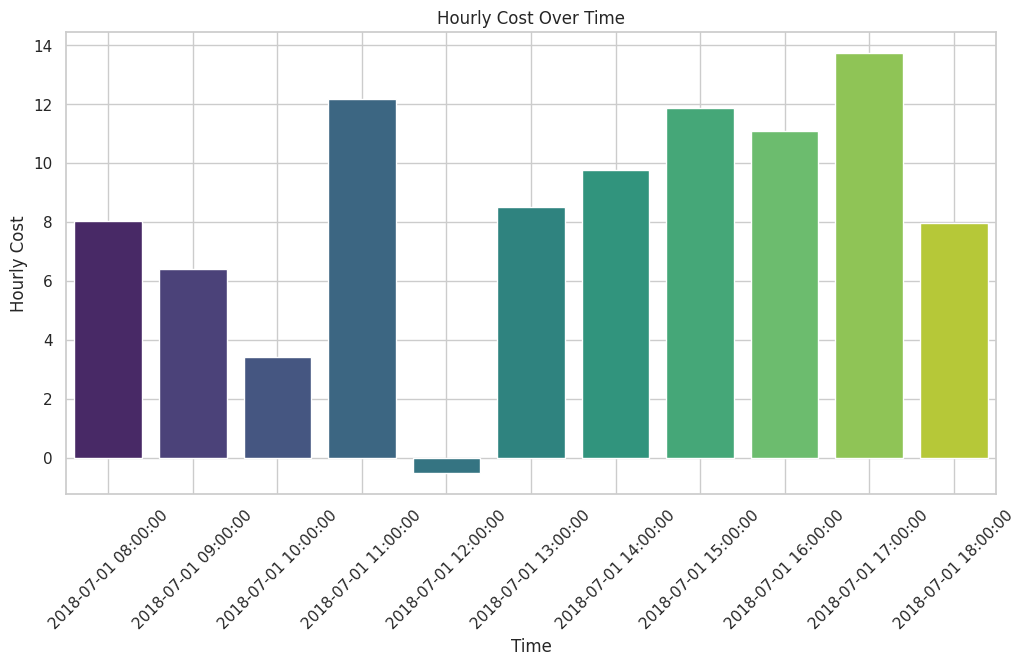

In [138]:
df_filtered, total_cost = calculate_cost(df, start_time, end_time)
print(f'Total Cost from {start_time} to {end_time}: {total_cost:.2f}')
visualize_cost(df_filtered)

## 計算 EV 離開時的滿意度

In [118]:
df = pd.read_csv('./Result/VDN/1/charging_records.csv', parse_dates=['arrival_time', 'departure_time'])

In [123]:
def calculate_satisfaction(df):
    # calculate final SoC
    df['satisfaction'] = df['final_soc'] / df['departure_soc']
    df['satisfaction'] = df['satisfaction'].clip(upper=1)  # limit satisfaction to 1
    return df

In [124]:
def visualize_satisfaction(df):
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")
    # use coolwarm color palette
    palette = sns.color_palette("coolwarm", df['requestID'].nunique())
    # create a dictionary to map requestID to color
    lut = dict(zip(df['requestID'].unique(), palette))
    # create a new column 'colors' by mapping requestID to color
    df['colors'] = df['requestID'].map(lut)
    
    # draw barplot
    barplot = sns.barplot(x='requestID', y='satisfaction', data=df, palette=df['colors'].tolist())
    
    # add data labels
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points')

    plt.xticks(rotation=45)
    plt.xlabel('Request ID')
    plt.ylabel('Satisfaction')
    plt.title('User Satisfaction')
    plt.ylim(0, 1.1)  # ensure the y-axis starts from 0 and ends at 1.1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [125]:
def calculate_average_satisfaction(df):
    # calculate average satisfaction
    average_satisfaction = df['satisfaction'].mean()
    return average_satisfaction

Average Satisfaction: 0.99


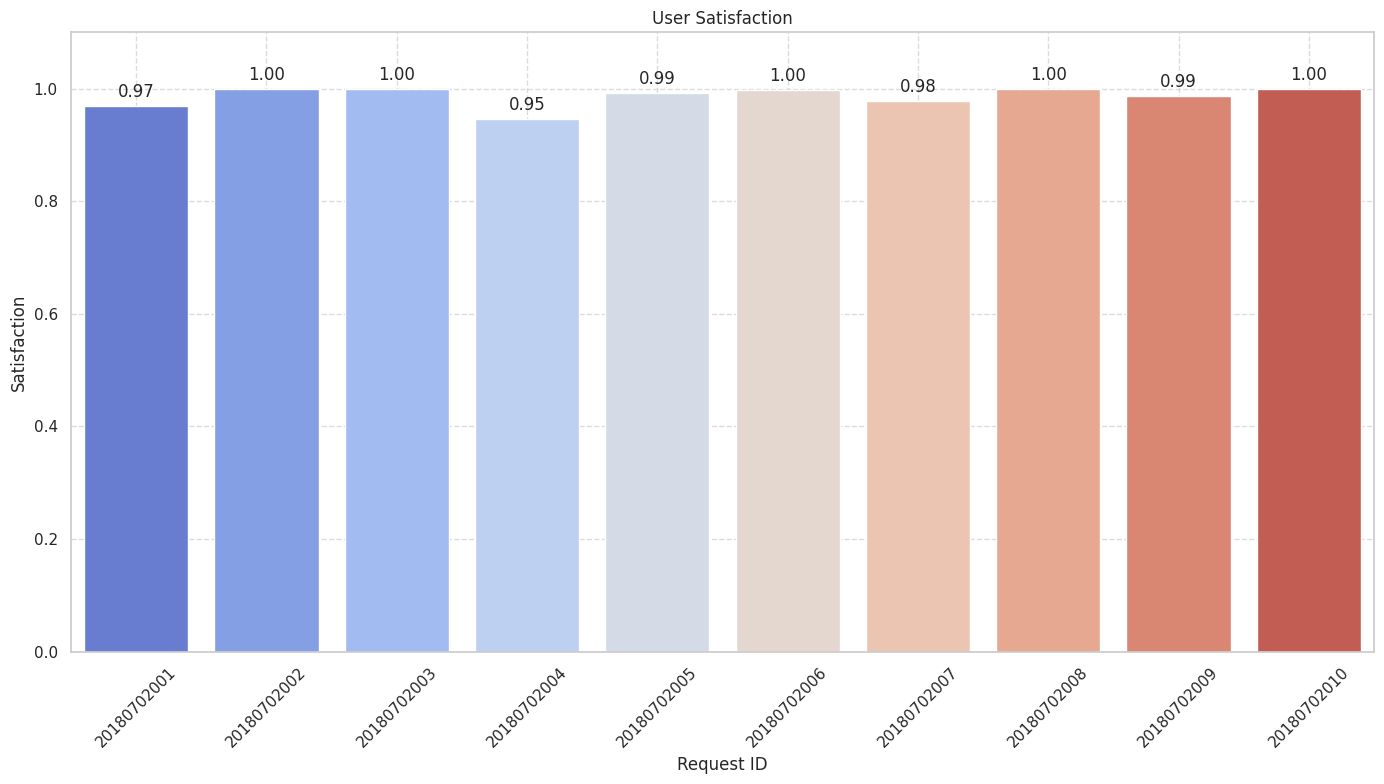

In [126]:
# calculate satisfaction
df = calculate_satisfaction(df)

# calculate average satisfaction
average_satisfaction = calculate_average_satisfaction(df)
print(f'Average Satisfaction: {average_satisfaction:.2f}')

# visualize satisfaction
visualize_satisfaction(df)

Total cost for GB-MARL from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $1794.72
Total overload penalty for GB-MARL from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $1712.80
Total cost for RandomPower from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $2652.79
Total overload penalty for RandomPower from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $2570.76
Total cost for DayAheadSchedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $25.80
Total overload penalty for DayAheadSchedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $0.00
Total cost for Unschedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $1657.89
Total overload penalty for Unschedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00: $1575.34


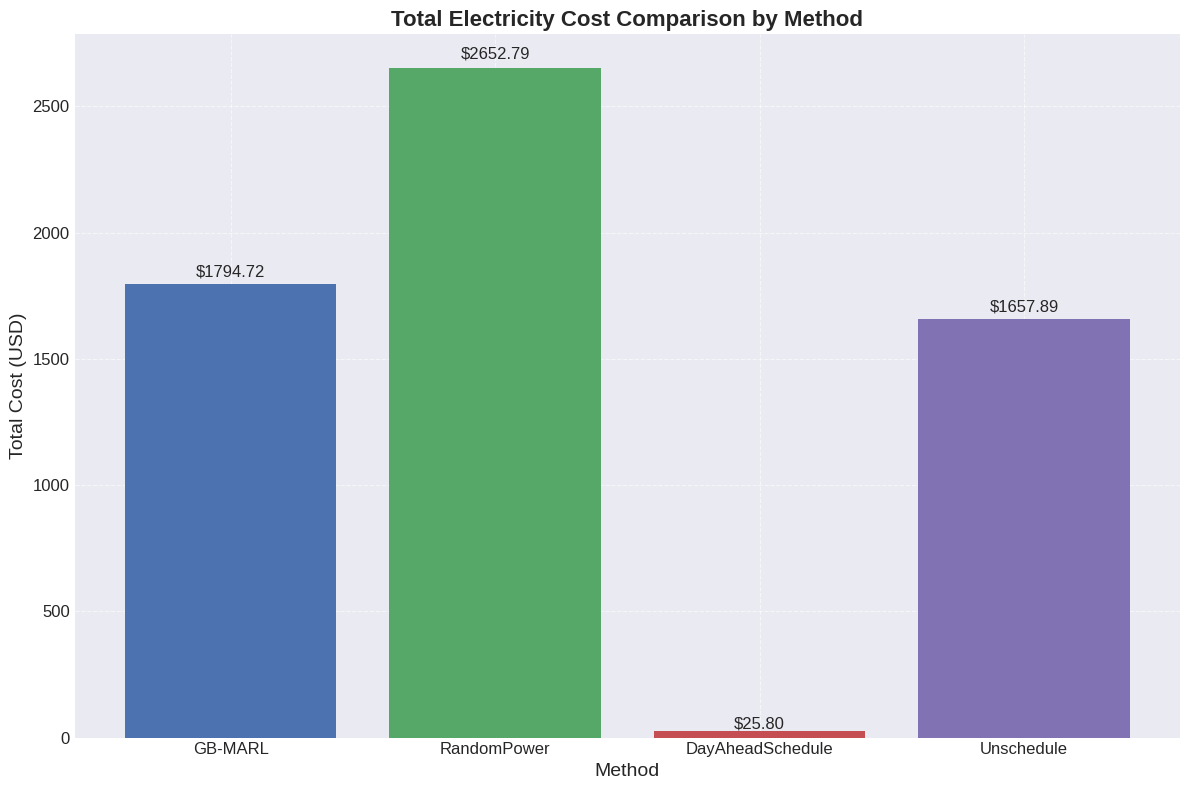

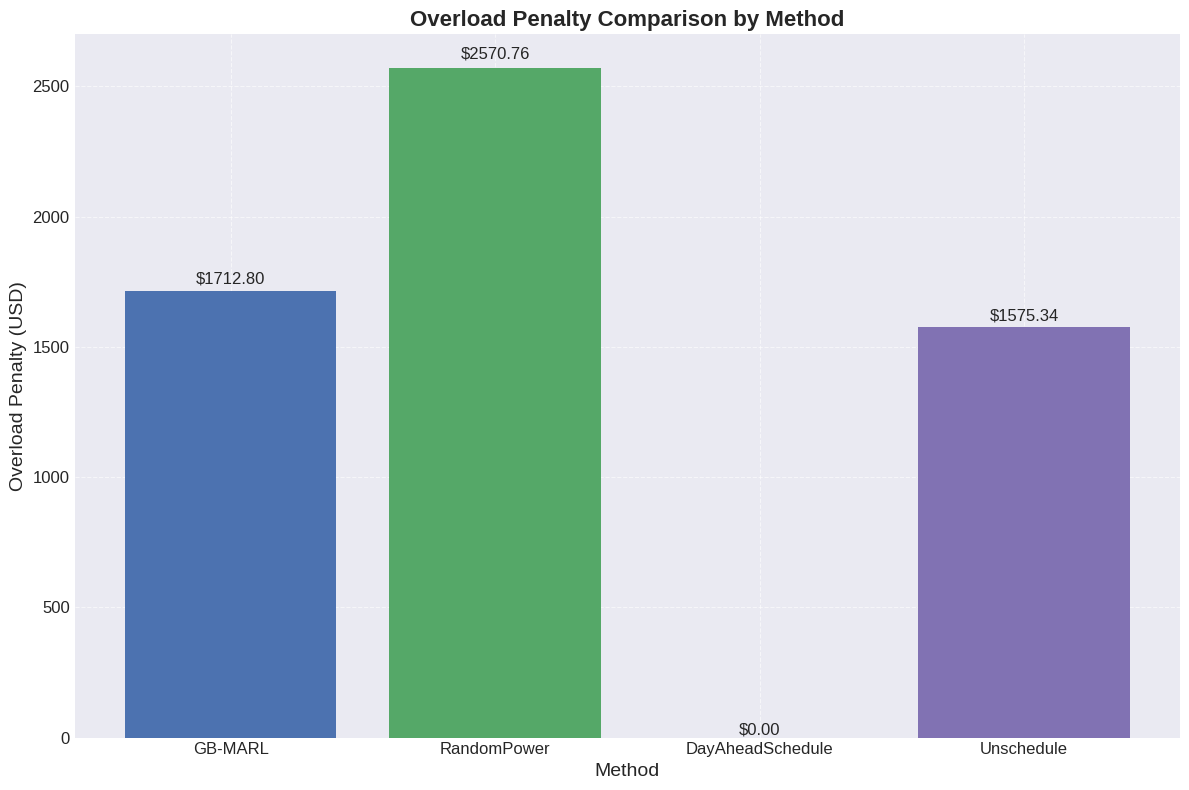

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 選定的時間範圍
start_time = datetime(2018, 7, 1)
end_time = datetime(2018, 7, 2)

def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

# 讀取實時價格數據
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_time, end_time)

# 設定 contract_capacity 和 capacity_price
contract_capacity = 200
capacity_price = 15

# 計算成本和超約罰金的函數
def calculate_cost_and_penalty(df, real_time_price, start_time, end_time):
    # 過濾時間範圍內的數據
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # 將實時價格合併到 df_filtered 中
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # 計算每個時間點的成本
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # 計算總成本
    total_cost = df_filtered['cost'].sum()

    # 計算每個月的超約罰金
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if max(overload, contract_capacity) != contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # 超出契約容量 10% 以下的部分
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # 超出契約容量 10% 以上的部分

        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)
    return df_filtered, total_cost, total_overload_penalty

# 讀取每個方法的 CSV 文件
MADDPG_file = './Result/GB-MARL-TEST/4/building_loading_history.csv'
Random_file = './Result/RandomPower/14/building_loading_history.csv'
DayAhead_file = './Result/DayAheadSchedule/26/building_loading_history.csv'
Unschedule_file = './Result/Unschedule/13/building_loading_history.csv'

methods = [MADDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'RandomPower', 'DayAheadSchedule', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)


# 計算每個方法的總成本和超約罰金
total_costs = []
overload_penalties = []
for df, method_name in zip(data_frames, method_names):
    df_filtered, total_cost, total_overload_penalty = calculate_cost_and_penalty(df, real_time_price, start_time, end_time)
    total_cost += total_overload_penalty  # 包含超約罰金在總成本中
    total_costs.append(total_cost)
    overload_penalties.append(total_overload_penalty)
    print(f'Total cost for {method_name} from {start_time} to {end_time}: ${total_cost:.2f}')
    print(f'Total overload penalty for {method_name} from {start_time} to {end_time}: ${total_overload_penalty:.2f}')

# 設置圖表樣式
plt.style.use('seaborn-darkgrid')

# 繪製總成本長條圖
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(method_names, total_costs, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# 添加標籤和圖例
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel('Total Cost (USD)', fontsize=14)
ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 顯示總成本在每個柱子上方
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval, f'${yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

# 繪製超約罰金長條圖
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(method_names, overload_penalties, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# 添加標籤和圖例
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel('Overload Penalty (USD)', fontsize=14)
ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 顯示超約罰金在每個柱子上方
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval, f'${yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Peak-to-Valley Ratio for GB-MARL from 2018-07-01 00:00:00 to 2018-07-02 00:00:00 (07:00 to 23:00): 1.79
Peak-to-Valley Ratio for RandomPower from 2018-07-01 00:00:00 to 2018-07-02 00:00:00 (07:00 to 23:00): 12.54
Peak-to-Valley Ratio for DayAheadSchedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00 (07:00 to 23:00): 9.22
Peak-to-Valley Ratio for Unschedule from 2018-07-01 00:00:00 to 2018-07-02 00:00:00 (07:00 to 23:00): 7.66


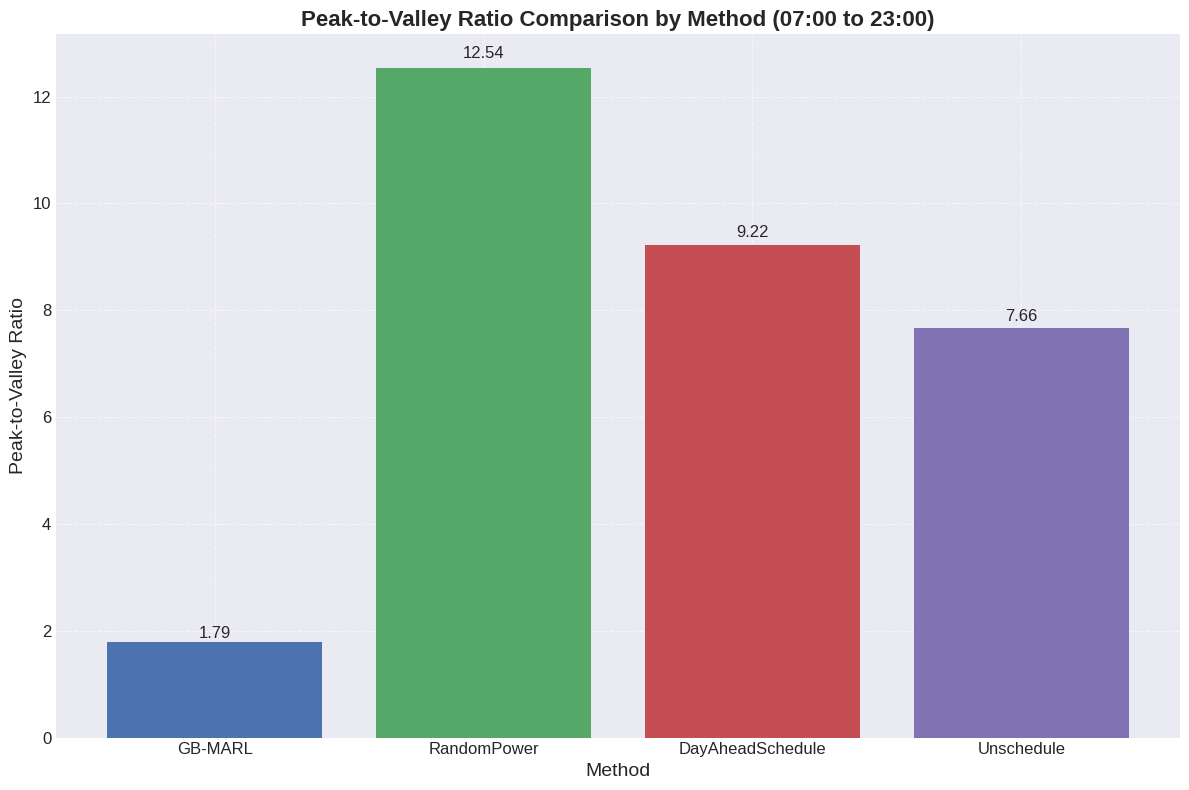

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time

# 讀取每個方法的 CSV 文件
MADDPG_file = './Result/MADDPG/312/building_loading_history.csv'
Random_file = './Result/RandomPower/14/building_loading_history.csv'
DayAhead_file = './Result/DayAheadSchedule/21/building_loading_history.csv'
Unschedule_file = './Result/Unschedule/13/building_loading_history.csv'

methods = [MADDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'RandomPower', 'DayAheadSchedule', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)

# 選定的時間範圍
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 2)

# 定義每天的時間範圍
start_time = time(7, 0, 0)
end_time = time(23, 0, 0)

# 計算每個方法的峰谷比
peak_to_valley_ratios = []
for df, method_name in zip(data_frames, method_names):
    # 過濾選定日期範圍內的數據
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered_date = df[(df['current_time'].dt.date >= start_date.date()) & (df['current_time'].dt.date <= end_date.date())].copy()

    # 過濾每天 7 點到 23 點的數據
    df_filtered_time = df_filtered_date[(df_filtered_date['current_time'].dt.time >= start_time) & (df_filtered_date['current_time'].dt.time <= end_time)].copy()

    # 計算峰值和谷值
    peak_load = df_filtered_time['total_load'].max()
    valley_load = df_filtered_time['total_load'].min()
    peak_to_valley_ratio = peak_load / valley_load
    peak_to_valley_ratios.append(peak_to_valley_ratio)
    print(f'Peak-to-Valley Ratio for {method_name} from {start_date} to {end_date} (07:00 to 23:00): {peak_to_valley_ratio:.2f}')

# 設置圖表樣式
plt.style.use('seaborn-darkgrid')

# 繪製長條圖
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(method_names, peak_to_valley_ratios, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# 添加標籤和圖例
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14)
ax.set_title('Peak-to-Valley Ratio Comparison by Method (07:00 to 23:00)', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# 顯示峰谷比在每個柱子上方
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

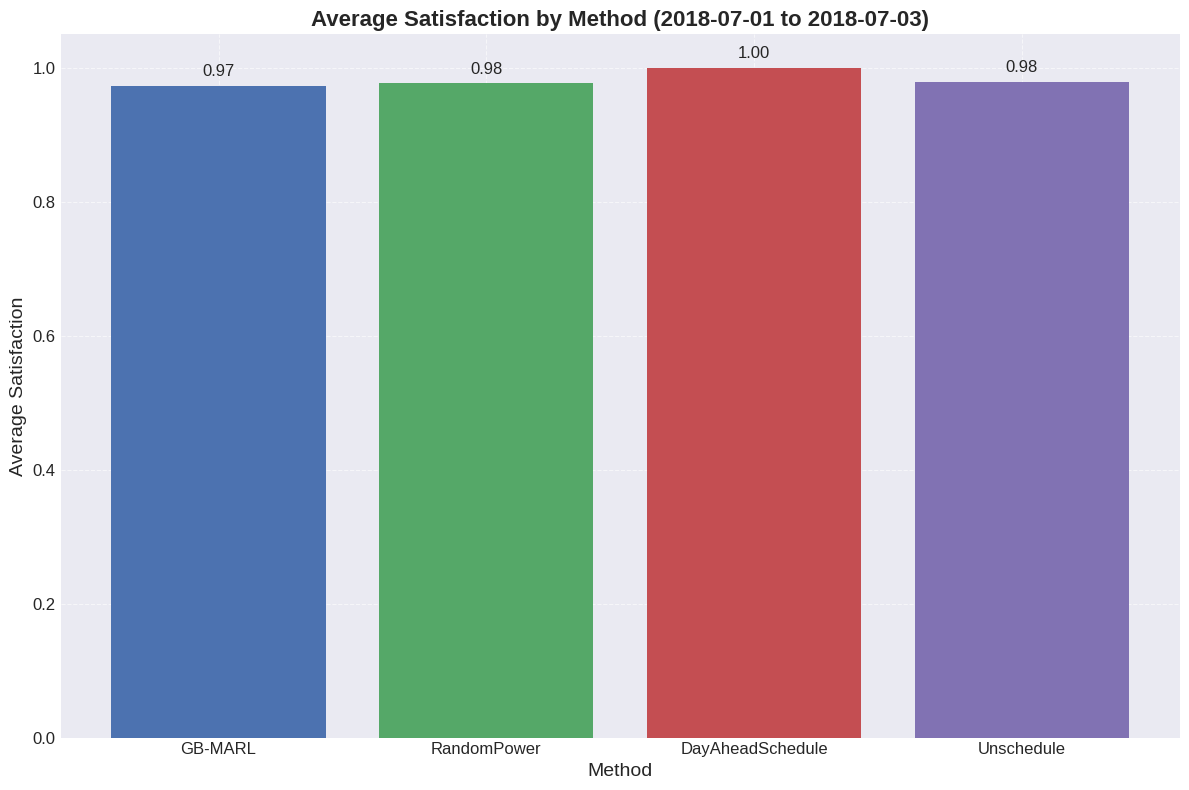

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 定義計算滿意程度的函數
def calculate_satisfaction(df):
    df['satisfaction'] = df.apply(lambda x: 1 if x['final_soc'] >= x['departure_soc'] else x['final_soc'] / x['departure_soc'], axis=1)
    df['departure_time'] = pd.to_datetime(df['departure_time'])
    return df

# 讀取每個方法的 CSV 文件
MADDPG_file = './Result/MADDPG/312/charging_records.csv'
Random_file = './Result/RandomPower/14/charging_records.csv'
DayAhead_file = './Result/DayAheadSchedule/21/charging_records.csv'
Unschedule_file = './Result/Unschedule/13/charging_records.csv'

methods = [MADDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'RandomPower', 'DayAheadSchedule', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    df = calculate_satisfaction(df)
    data_frames.append(df)

# 選定的日期範圍
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 3)

# 計算每個方法的平均滿意程度
avg_satisfaction = []

for df in data_frames:
    df_filtered = df[(df['departure_time'] >= start_date) & (df['departure_time'] <= end_date)]
    avg_satisfaction.append(df_filtered['satisfaction'].mean())

# 繪製每個方法的平均滿意程度
plt.figure(figsize=(12, 8))
bars = plt.bar(method_names, avg_satisfaction, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# 添加標籤和圖例
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method ({start_date.date()} to {end_date.date()})', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# 顯示平均滿意度在每個柱子上方
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

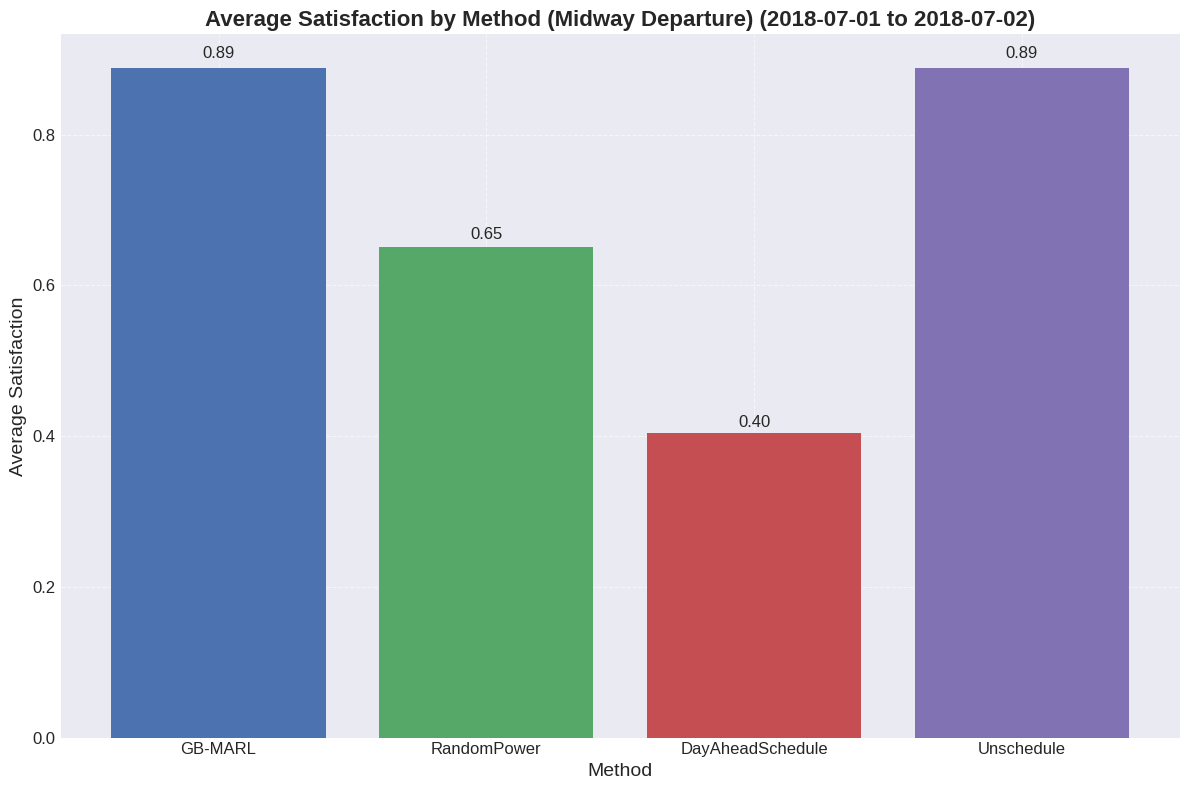

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 定義計算中途離開滿意程度的函數
def calculate_midway_satisfaction(df, start_date, end_date):
    # 先計算每個記錄的中間時間
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    
    # 過濾選定日期範圍內的記錄
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]

    # 對每個記錄計算在中間時間的滿意程度
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        if not mid_time_index.any():
            # 如果没有精确匹配的时间戳，则选择最接近的时间戳
            closest_index = (df['requestID'] == requestID) & (df['current_time'] >= start_date) & (df['current_time'] < end_date)
            closest_row = df[closest_index].iloc[(df[closest_index]['current_time'] - mid_time).abs().argsort()[:1]]
            midway_soc = closest_row['soc'].values[0]
        else:
            midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    return pd.Series(satisfaction)

# 讀取每個方法的 soc_history 文件
MADDPG_file = './Result/MADDPG/68/soc_history.csv'
Random_file = './Result/RandomPower/14/soc_history.csv'
DayAhead_file = './Result/DayAheadSchedule/21/soc_history.csv'
Unschedule_file = './Result/Unschedule/13/soc_history.csv'

methods = [MADDPG_file, Random_file, DayAhead_file, Unschedule_file]
method_names = ['GB-MARL', 'RandomPower', 'DayAheadSchedule', 'Unschedule']
data_frames = []

# 選定的日期範圍
start_date = datetime(2018, 7, 1)
end_date = datetime(2018, 7, 2)

for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_date, end_date)
    data_frames.append(satisfaction)

# 計算每個方法的平均滿意程度
avg_satisfaction = [s.mean() for s in data_frames]

# 繪製每個方法的平均滿意程度
plt.figure(figsize=(12, 8))
bars = plt.bar(method_names, avg_satisfaction, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# 添加標籤和圖例
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure) ({start_date.date()} to {end_date.date()})', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# 顯示平均滿意度在每個柱子上方
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()